In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing
from lightfm import LightFM
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix 
from sklearn.metrics import roc_auc_score
import time
from lightfm.evaluation import auc_score
import pickle
import re
import seaborn as sns


books = pd.read_csv('/home/gswyhq/github_projects/Recommender-System-LightFM/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('/home/gswyhq/github_projects/Recommender-System-LightFM/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('/home/gswyhq/github_projects/Recommender-System-LightFM/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:30

In [2]:
ratings.shape

(1149780, 3)

In [3]:
books.shape

(271360, 8)

In [4]:
users.shape

(278858, 3)

In [5]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [9]:
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [10]:
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [11]:
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


In [12]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [13]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [14]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

In [15]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [16]:
books.yearOfPublication.isnull().sum()

0

In [17]:
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

In [18]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

In [19]:
users.Age = users.Age.fillna(users.Age.mean())

In [20]:
users.Age = users.Age.astype(np.int32)

In [21]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [22]:
ratings = ratings[ratings.userID.isin(users.userID)]

In [23]:
ratings_explicit = ratings_new[ratings_new.bookRating != 0]

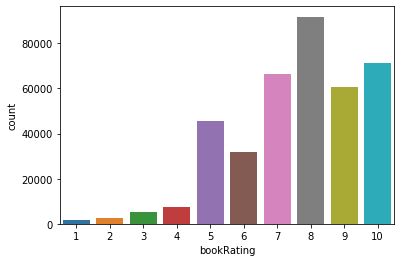

In [24]:
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

In [25]:
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 20].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 20].index)]
ratings_explicit.shape

(217729, 3)

In [26]:
def informed_train_test(rating_df, train_ratio):
    split_cut = np.int(np.round(rating_df.shape[0] * train_ratio))
    train_df = rating_df.iloc[0:split_cut]
    test_df = rating_df.iloc[split_cut::]
    test_df = test_df[(test_df['userID'].isin(train_df['userID'])) & (test_df['ISBN'].isin(train_df['ISBN']))]
    id_cols = ['userID', 'ISBN']
    trans_cat_train = dict()
    trans_cat_test = dict()
    for k in id_cols:
        cate_enc = preprocessing.LabelEncoder()
        trans_cat_train[k] = cate_enc.fit_transform(train_df[k].values)
        trans_cat_test[k] = cate_enc.transform(test_df[k].values)

    # --- Encode ratings:
    cate_enc = preprocessing.LabelEncoder()
    ratings = dict()
    ratings['train'] = cate_enc.fit_transform(train_df.bookRating)
    ratings['test'] = cate_enc.transform(test_df.bookRating)

    n_users = len(np.unique(trans_cat_train['userID']))
    n_items = len(np.unique(trans_cat_train['ISBN']))


    train = coo_matrix((ratings['train'], (trans_cat_train['userID'], \
                                                          trans_cat_train['ISBN'])) \
                                      , shape=(n_users, n_items))
    test = coo_matrix((ratings['test'], (trans_cat_test['userID'], \
                                                        trans_cat_test['ISBN'])) \
                                     , shape=(n_users, n_items))
    return train, test, train_df

In [27]:
train, test, raw_train_df = informed_train_test(ratings_explicit, .8)

In [28]:
start_time = time.time()
model=LightFM(no_components=115,learning_rate=0.027,loss='warp')
model.fit(train,epochs=12,num_threads=4)
# with open('saved_model','wb') as f:
#     saved_model={'model':model}
#     pickle.dump(saved_model, f)
auc_train = auc_score(model, train).mean()
auc_test = auc_score(model, test).mean()

print("--- Run time:  {} mins ---".format((time.time() - start_time)/60))
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

--- Run time:  1.2938527822494508 mins ---
Train AUC Score: 0.9798632860183716
Test AUC Score: 0.8240739703178406


In [29]:
user_item_matrix = raw_train_df.pivot(index='userID', columns='ISBN', values='bookRating')
user_item_matrix.fillna(0, inplace = True)
user_item_matrix = user_item_matrix.astype(np.int32)
print(user_item_matrix.shape)
user_item_matrix.head()

(2604, 93614)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B0000T6KHI,B0000T6KIM,B0000VZEJQ,B0000X8HIE,B00011SOXI,B00013AX9E,B0001FZGRQ,B0001GMSV2,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
def user_item_dikts(interaction_matrix, items_df):
    user_ids = list(interaction_matrix.index)
    user_dikt = {}
    counter = 0 
    for i in user_ids:
        user_dikt[i] = counter
        counter += 1

    item_dikt ={}
    for i in range(items_df.shape[0]):
        item_dikt[(items_df.loc[i,'ISBN'])] = items_df.loc[i,'bookTitle']
    
    return user_dikt, item_dikt    
        

In [31]:
def similar_recommendation(model, interaction_matrix, user_id, user_dikt, 
                               item_dikt,threshold = 0,number_rec_items = 15):

    #Function to produce user recommendations

    n_users, n_items = interaction_matrix.shape
    user_x = user_dikt[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interaction_matrix.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interaction_matrix.loc[user_id,:][interaction_matrix.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    score_list = scores[0:number_rec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dikt[x]))
    scores = list(pd.Series(score_list).apply(lambda x: item_dikt[x]))

    print("Items that were liked by the User:")
    counter = 1
    for i in known_items[:25]:
        print(str(counter) + '- ' + i)
        counter+=1

    print("\n Recommended Items:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + i)
        counter+=1
#     return score_list

In [32]:
def users_for_item(model,interaction_matrix,ISBN,number_of_user):
  
    #Funnction to produce a list of top N interested users for a given item

    n_users, n_items = interaction_matrix.shape
    x = np.array(interaction_matrix.columns)
    scores = pd.Series(model.predict(np.arange(n_users), np.repeat(x.searchsorted(ISBN),n_users)))
    user_list = list(interaction_matrix.index[scores.sort_values(ascending=False).head(number_of_user).index])
    return user_list 

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

def item_emdedding_distance_matrix(model,interaction_matrix):

#     Function to create item-item distance embedding matrix

    df_item_norm_sparse = csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interaction_matrix.columns
    item_emdedding_distance_matrix.index = interaction_matrix.columns
    return item_emdedding_distance_matrix

def also_bought_recommendation(item_emdedding_distance_matrix, item_id, 
                             item_dikt, n_items = 4):

#     Function to create item-item recommendation

    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    
    print("Item of interest :{}".format(item_dikt[item_id]))
    print("Items that are frequently bought together:")
    counter = 1
    for i in recommended_items:
        print(str(counter) + '- ' +  item_dikt[i])
        counter+=1
    return recommended_items

In [34]:
user_dikt, item_dikt = user_item_dikts(user_item_matrix, books)

In [35]:
similar_recommendation(model, user_item_matrix, 254, user_dikt, item_dikt,threshold = 7)

Items that were liked by the User:
1- The Devil You Know
2- Harlequin Valentine
3- Shout!: The Beatles in Their Generation
4- Sandman: The Dream Hunters
5- Dream Country (Sandman, Book 3)
6- Assata: An Autobiography (Lawrence Hill &amp; Co.)
7- The Golden Compass (His Dark Materials, Book 1)
8- The Fellowship of the Ring (The Lord of the Rings, Part 1)
9- The Hobbit: or There and Back Again
10- Harry Potter and the Sorcerer's Stone (Book 1)
11- Something Wicked This Way Comes
12- Martian Chronicles
13- Animal Farm
14- 1984
15- The Dark Half
16- Harry Potter and the Goblet of Fire (Book 4)
17- Harry Potter and the Prisoner of Azkaban (Book 3)
18- Harry Potter and the Prisoner of Azkaban (Book 3)
19- Harry Potter and the Chamber of Secrets (Book 2)
20- Harry Potter and the Chamber of Secrets (Book 2)
21- The Bonesetter's Daughter
22- The Wolves in the Walls
23- Stardust
24- Martian Chronicles
25- American Gods: A Novel

 Recommended Items:
1- Harry Potter and the Order of the Phoenix (Bo

In [36]:
users_for_item(model, user_item_matrix, '0195153448', 10)

[98391, 142772, 5499, 83443, 203820, 73399, 136735, 96473, 21684, 26443]

In [37]:
item_embedings = item_emdedding_distance_matrix(model,user_item_matrix)
also_bought_recommendation(item_embedings,'B0000T6KHI' ,item_dikt)


MemoryError: Unable to allocate array with shape (8763580996,) and data type int64

代码及训练数据来源：https://github.com/nxs5899/Recommender-System-LightFM